* 使用torchvision加载并预处理CIFAR-10数据集
* 定义神经网络
* 定义损失函数和优化器
* 训练网络并更新参数
* 测试网络

CIFAR-10数据加载及预处理
    
    CIFAR-10是一个常用的彩色图片数据集，它有10个类别："airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"
    每张图片都是3*32*32，也即3-通道彩色图片，分辨率为32*32

In [1]:
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show=ToPILImage()  #可以把Tensor转化成Image，方便可视化
import torch 
torch.cuda.current_device()

0

In [2]:
'''
第一次运行程序torchvision会自动下载cifar-10数据集，大于100M，需要花一定的时间，如果已经下载，那么可以
通过root参数来指定
'''
#定义对数据的预处理
transform=transforms.Compose([transforms.ToTensor(), #转化为Tensor
                            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

#training data
trainset=tv.datasets.CIFAR10(root="data",train=True,download=True,transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True)
#testing data
testset=tv.datasets.CIFAR10(root="data",train=False,download=True,transform=transform)
testloader=torch.utils.data.DataLoader(testset,batch_size=4,shuffle=True)

classes=("plane","car","bird","cat","deer","dog","frog","horse","ship","truck")

Files already downloaded and verified
Files already downloaded and verified


Dataset对象是一个数据集，可以按照下标访问，返回形如(data,label)的数据

In [3]:
trainset[100][0].shape

torch.Size([3, 32, 32])

ship


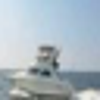

In [4]:
(data,label)=trainset[100]
print(classes[label])

#(data+1)/2是为了还原被归一化的数据
show((data+1)/2).resize((100,100))

DataLoader是一个可迭代对象，它将dataset返回的每一条数据拼接成一个batch，并提供多线程加速优化和数据打乱等操作。当程序对dataset的所有数据
遍历完一遍之后，相应的对Dataloader也完成了一次迭代

       ship         car       horse       horse


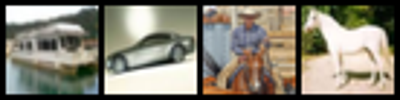

In [5]:
dataiter=iter(trainloader)
images,labels=dataiter.next()
print(" ".join("%11s"%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images+1)/2)).resize((400,100))

定义网络，这是个三通道的图片

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.conv2=nn.Conv2d(6,16,5)
        self.pool=nn.MaxPool2d(2,2)
        self.fc1=nn.Linear(5*5*16,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(x.size()[0],-1) #将数据平展为1维
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
    
net=Net()
print(net)
        

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


定义损失器和优化器(loss和optimizer)

In [8]:
from torch import optim
criterion=nn.CrossEntropyLoss() #交叉熵损失函数
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

# 训练网络

所有网络的训练流程都类似的，不断执行如下流程：
* 输入数据
* 前向传播+反向传播
* 更新参数

In [9]:
torch.set_num_threads(8)
for epoch in range(2):
    
    running_loss=0.0
    for i,data in enumerate(trainloader,0):
        
        #输入数据
        inputs,labels=data
        
        #梯度清零
        optimizer.zero_grad()
        
        #forward+backward
        outputs=net(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        
        #更新参数
        optimizer.step()
        
        #打印log信息
        #loss 是一个scalar，需要使用loss.item()来获取数值，不能使用loss[0]
        running_loss+=loss.item()
        if i % 2000 ==1999:
            #每2000个batch打印一下训练状态
            print("[%d,%5d] loss: %.3f" %(epoch+1,i+1,running_loss/2000))
            running_loss=0.0
print("Finished Training")

[1, 2000] loss: 2.194
[1, 4000] loss: 1.871
[1, 6000] loss: 1.686
[1, 8000] loss: 1.590
[1,10000] loss: 1.521
[1,12000] loss: 1.437
[2, 2000] loss: 1.365
[2, 4000] loss: 1.373
[2, 6000] loss: 1.320
[2, 8000] loss: 1.303
[2,10000] loss: 1.299
[2,12000] loss: 1.261
Finished Training


此处仅训练了2个epoch(遍历完一遍数据集称之为一个epoch)，来看看网络有没有效果。将测试图片输入到网络中，计算它的label，然后与实际的label比较

实际的label:
     deer     bird    truck     ship


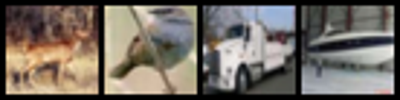

In [10]:
dataiter=iter(testloader)
images,labels=dataiter.next()
print("实际的label:\n"," ".join("%08s"%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid(images/2-0.5)).resize((400,100))

In [11]:
#计算图片在每个类别上的分数
outputs=net(images)
#得分最高的那个类
_,predicted=torch.max(outputs.data,1)
print("预测结果：\n"," ".join("%5s"%classes[predicted[j]] for j in range(4)))

预测结果：
  deer  bird truck plane


In [13]:
correct=0
total=0

#由于测试的时候不需要求导，可以暂时关闭autograd,提高速度，节约内存

with torch.no_grad():
    for data in testloader:
        images,labels=data
        outputs=net(images)
        _,predicted=torch.max(outputs,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum()
        
print("10000张测试集中的准确率为：{}".format(100*correct/total))

10000张测试集中的准确率为：56


训练的准确率远比随机猜测要好，证明网络确实学到了东西

在GPU训练：
* 

In [14]:
device=torch.device("cuda:0")
net.to(device)
images=images.to(device)
labels=labels.to(device)
output=net(images)
loss=criterion(output,labels)

loss

tensor(2.6779, device='cuda:0', grad_fn=<NllLossBackward>)